#Recurrent Neural Networks from scratch
In this lab you will implement a basic cell from a Recurrent Neural Network (RNN). The RNN will try to reconstruct a sinusoidal wave. 


In [1]:
import torch
import math
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

torch.manual_seed(8989)

##LSTM basic cell

We will implement an LSTM cell in pytorch. Remember the main equations of LSTMs:

$\begin{aligned}
  &x^\prime = \left(\begin{array}{c} h^{<t-1>}\\ x^{<t>} \end{array}\right)\\
  &i = \sigma(\mathbf{W}_{hi}x^\prime + b_{hi})\\
  &f = \sigma(\mathbf{W}_{hf}x^\prime + b_{hf})\\
  &o = \sigma(\mathbf{W}_{ho}x^\prime + b_{ho})\\
  &g = \tanh(\mathbf{W}_{hg}x^\prime + b_{hg})\\
  &c^{<t>} = f \odot c^{<t-1>}+i\odot g\\
  &h^{<t>} = o \odot \tanh(c^{<t>})
\end{aligned}$

Where:
- $x^{<t>}$: input vector at time $t$ 
- $h^{<t>}$: new state
- $c^{<t>}$: new cell
- $h^{<t-1>}$: previous state
- $c^{<t-1>}$: previous cell

Remember that to implement a layer, you have to create a new class that inherits from `nn.Module`. There are two functions you have to think about:

`__init__` function:


*   Look carefully at the arguments given in its signature.
*   Create tensors for the weights of the layer with the appropriate shape. The shape of our weights is determined by the arguments `input_size`, `hidden_size`.
*   Create the bias tensors with the appropriate shapes.
*   **Remember to wrap the tensors in `torch.nn.Parameter` so they become differentiable parameters**

`forward` function:


*   Given a new input $x^{<t>}$, the previous hidden vector $h^{<t-1>}$ and the previous cell vector $c^{<t-1>}$, calculate $h^{<t>}$ and $c^{<t>}$ (return the output as a tuple)

**EXERCISE:** Implement the layer `LSTMCell` following the instructions above.

In [23]:
class LSTMCell(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size

        self.w_hi = None
        self.b_hi = None
        self.w_hf = None
        self.b_hf = None
        self.w_hg = None
        self.b_hg = None
        self.w_ho = None
        self.b_ho = None

        # Note, both h and c have the same dimension (hidden_size)

        ### WRITE YOUR CODE HERE (~16 lines) ### 
        self.w_hi = torch.zeros((hidden_size+input_size))
        self.b_hi = torch.zeros((hidden_size))
        
        self.w_hf = torch.zeros((hidden_size+input_size))
        self.b_hf = torch.zeros((hidden_size))
       
        self.w_hg = torch.zeros((hidden_size+input_size))
        self.b_hg = torch.zeros((hidden_size))
        
        self.w_ho = torch.zeros((hidden_size+input_size))
        self.b_ho = torch.zeros((hidden_size))

        self.w_hi = torch.nn.Parameter(self.w_hi)
        self.b_hi = torch.nn.Parameter(self.b_hi)
        self.w_hf = torch.nn.Parameter(self.w_hf)
        self.b_hf = torch.nn.Parameter(self.b_hf)
        self.w_hg = torch.nn.Parameter(self.w_hg)
        self.b_hg = torch.nn.Parameter(self.b_hg)
        self.w_ho = torch.nn.Parameter(self.w_ho)
        self.b_ho = torch.nn.Parameter(self.b_ho)
        ########################

        # init parameters
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weigth in self.parameters():
            with torch.no_grad():
                weigth.uniform_(-stdv, stdv)

    def forward(self, x, h, c):
        '''Perform a one step forward pass.

        Input:
        - x: input tensor at time t (input_size)
        - h: hidden state at time t-1  (hidden_size). Set all zeros for first hidden state.
        - c: cell state at time t-1  (hidden_size). Set all zeros for first cell state.

        Output: a tuple with two values
        - h: next hidden state (hidden_size)
        - c: next cell state (hidden_size)
        '''
        next_h = None
        next_c = None
        ### WRITE YOUR CODE HERE (~7 lines) ###
        x_prima = torch.cat((h,x))
        i = torch.nn.functional.sigmoid(torch.matmul(self.w_hi, x_prima) + self.b_hi)
        f = torch.nn.functional.sigmoid(torch.matmul(self.w_hf, x_prima) + self.b_hf)
        o = torch.nn.functional.sigmoid(torch.matmul(self.w_ho, x_prima) + self.b_ho)
        g = torch.nn.functional.tanh(   torch.matmul(self.w_hg, x_prima) + self.b_hg)
        #next_c = torch.mul(f,c) + torch.mul(i, g)
        #print(f.shape)
        next_c = f*c + i*g
        #next_h = torch.mul(o, torch.nn.functional.tanh(next_c))
        next_h = o * torch.nn.functional.tanh(next_c)
        ########################
        return next_h, next_c


## A class on top the LSTM to predict the new wave value

As the output of the LSTM is $h^{<t>}$, we add a feed forward layer on top of it to predict the next wave value.

In [24]:
class WaveClasif(torch.nn.Module):
    '''A MLP on top of LSTM to predict the nexw wave value'''
    def __init__(self, input_size, hidden_size, output_size):
        super(WaveClasif, self).__init__()
        self.rnn = LSTMCell(input_size, hidden_size)
        self.fcc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, h, c):
        next_h, next_c = self.rnn(x, h, c)
        yhat = self.fcc(next_h)
        return yhat, next_h, next_c

## Data preparation

We will create the training data. Each example is composed by a pair $(x^{(i)}, y^{(i)})$ where:

- $x^{(i)}$ is a vector corresponding to the wave values $(i,\ldots,i+\mathrm{seq\_len})$ 
- $y^{(i)}$ is a vector corresponding to the wave values $(i+1,\ldots,i+\mathrm{seq\_len}+1)$



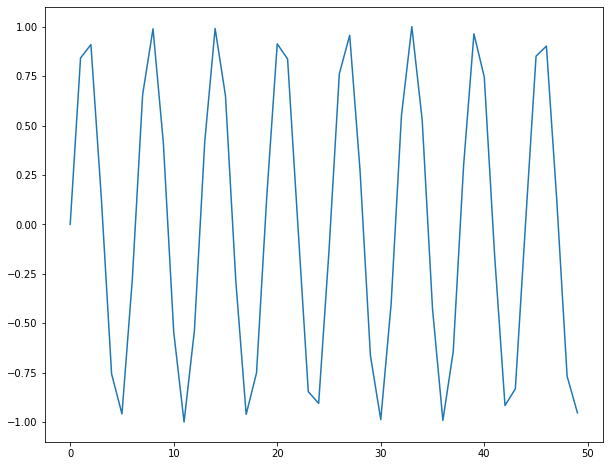

In [25]:
sin_wave = [math.sin(x) for x in torch.arange(200)]
seq_len = 50
num_records = len(sin_wave)

plt.plot(sin_wave[:50])
plt.show()

##### prepare the training data

X = []
Y = []
for i in range(num_records - seq_len):
    X.append(torch.tensor([0] + sin_wave[i:i+seq_len - 1]))
    Y.append(torch.tensor(sin_wave[i:i+seq_len]))
X = torch.stack(X)
Y = torch.stack(Y)


## Train `WaveClasif`(and the LSTM)

Now we will train the WaveClasif` module with the training data. 

The training procedure will be the following:

- for each training instance $(x^{(i)}, y^{(i)})$ do:
 - init loss to zero
 - set $h$ and $c$ to zero
 - for j in $1\ldots$ `seq_len`
   - create a one-hot vector $x$ with all zeros except the $j$th component, which is $x^{(i)}_j$
   - call `WaveClasif` with $x$, $h$ and $c$
   - increase loss using the `criterion`function, comparing the output of `WaveClasif`with $y^{(i)}_j$

**EXERCISE**: complete the code within the training loop. **You should obtain a training loss of circa 8.79**

In [26]:
learning_rate = 0.001
nepoch = 50
T = seq_len                   # length of sequence
hidden_size = 100
output_size = 1
rnn = WaveClasif(seq_len, hidden_size, output_size)
criterion = torch.nn.MSELoss() # criterion is mean square loss (sqrt(y_hat^2 - y))
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate) # Stochastic gradient descend
losses = []
for epoch in range(nepoch):
    for x,y in zip(X, Y):
        ### WRITE YOUR CODE HERE ###
        loss = 0
        # initialize h with zeros
        h = torch.zeros(hidden_size)
        c = torch.zeros(hidden_size)
        for t in range(seq_len):
            new_x = torch.zeros_like(x)
            new_x[t] = x[t]
            yhat, h, c = rnn(new_x, h, c)
            loss += criterion(yhat[0], y[t])
        ########################
        losses.append(loss.item())
        optimizer.zero_grad() # init gradients
        loss.backward()       # compute gradients
        optimizer.step()      # update step
    print(loss.item())
print(f'Train loss {sum(losses)/len(losses)}')


25.0325870513916
24.822202682495117
21.703428268432617
9.966867446899414
7.048239231109619
6.972900867462158
6.5746941566467285
5.72760009765625
5.420892715454102
5.213514804840088
4.996307373046875
4.758045196533203
4.500833988189697
4.23732852935791
4.132483005523682
3.656010150909424
3.6106033325195312
3.373617649078369
3.2243094444274902
3.0430221557617188
2.811896800994873
2.52290940284729
2.2184221744537354
1.9581480026245117
1.757705569267273
1.6102217435836792
1.503909945487976
1.4275529384613037
1.3722145557403564
1.3313723802566528
1.3004904985427856
1.2764862775802612
1.2572896480560303
1.2415083646774292
1.2282017469406128
1.216729760169983
1.2066508531570435
1.197657585144043
1.1895294189453125
1.1821084022521973
1.1752769947052002
1.168944001197815
1.1630436182022095
1.1575208902359009
1.1523306369781494
1.1474356651306152
1.1428077220916748
1.138419270515442
1.1342496871948242
1.1302783489227295
Train loss 3.614788645005226


## Test the model

We will create a slightly shifted sinusoidal wave and complete it with the results of the trained RNN.

The testing procedure is almost the same to the training procedure, except:

- we iterate through the test dataset
- we only calculate the loss for the last time step
- we do not backpropagate the losses

In summary, write the same code you wrote for training, but **discard all management of the `loss` variable**.

**EXERCISE**: complete the code within the test loop. **You should obtain a test loss of circa $1.21e^{-4}$**

Test loss: 0.00044312204422413494


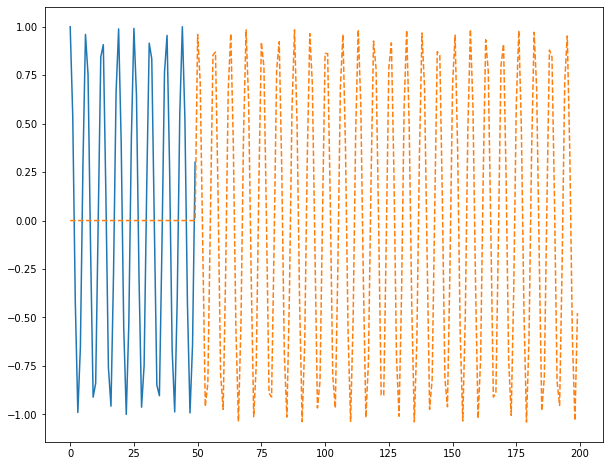

In [27]:
sin_wave_test = [math.sin(math.pi * 0.5 + x) for x in torch.arange(200)]
X_test = []
Y_test = []
for i in range(num_records - seq_len):
    X_test.append(torch.tensor(sin_wave_test[i:i+seq_len]))
    Y_test.append(torch.tensor(sin_wave_test[i+seq_len]))
X_test = torch.stack(X_test)
Y_test = torch.stack(Y_test)

plt.plot(sin_wave_test[:seq_len])

generated_wave = [0] * seq_len
test_losses = []
with torch.no_grad():
    for x,y in zip(X_test, Y_test):
        ### WRITE YOUR CODE HERE ###
        # initialize h with zeros
        h = torch.zeros(hidden_size)
        c = torch.zeros(hidden_size)
        for t in range(seq_len):
            new_x = torch.zeros_like(x)
            new_x[t] = x[t]
            yhat, h, c = rnn(new_x, h, c)
        ########################
        # last yhat predicts y
        generated_wave.append(yhat[0])
        # loss is calculated only for the last time step
        loss = criterion(yhat[0], y)
        test_losses.append(loss.item())
print(f'Test loss: {sum(test_losses)/len(test_losses)}')
plt.plot(generated_wave, '--')
plt.show()